# Interommatidial angle of the *Megaphragma* compound eye
- Amount in which they sample from overlapping receptive fields 
- Compare interommatidial angle with the spacing of lens centers

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations
#import statsmodels.api as sm
from sklearn.decomposition import PCA

from cx_analysis.catmaid_queries import skels_in_annot, skel_compact_detail, node_coords
from cx_analysis.vis.hex_lattice import om_to_hex

Data: 
Rhabdom centerlines drawn on CATMAID for each ommatidia in specimen 1. (nc)

**right eye** 2019-1-29 
- annotation: rhabdom_centerline
- name: omXY_axon_to_lens
- n = 29
**left eye** 2021-6-17
- annotation: rhabdom_centerlineLEFT
- name: omXYL_axon_to_lens
- n = 29

In [2]:
tp = '210615'
data_path = f'~/Data/{tp}_lamina/'  

optics_df = pd.read_csv(data_path + 'optics_df.csv', index_col=0).rename_axis('ommatidium')
display(optics_df)

,lense diameter (stack),lense thickness,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,Mean Microv. Ang. Turn,rhabdom_len,radius_in,radius_out
ommatidium,,,,,,,,,,
E7,NaN,NaN,NaN,NaN,1.782745,1.247685,21.751852,13.960,NaN,NaN
E6,6.98073,2.96461,3.40063,5.523305,2.262045,1.454785,18.094937,13.352,1.883024,1.876237
E5,NaN,NaN,NaN,NaN,2.417245,2.116145,30.106173,11.088,NaN,NaN
E4,8.07757,2.65285,3.67528,6.701025,2.970095,2.274005,27.848148,12.704,3.354193,3.158781
D7,NaN,NaN,NaN,NaN,1.917540,1.261355,15.050617,14.032,NaN,NaN
D6,NaN,NaN,NaN,NaN,1.980355,1.238485,7.805063,13.976,NaN,NaN
D5,8.16472,3.58905,3.73574,6.450405,2.444485,2.152785,24.836709,13.520,2.391452,2.508352
D4,NaN,NaN,NaN,NaN,2.918445,2.018030,30.330864,13.792,NaN,NaN
D3,7.23770,2.80608,3.96908,6.664940,2.949440,2.042290,23.988889,14.640,2.698913,4.511064


In [3]:
# catmaid access 
cm_token = os.environ['CM_TOKEN']
cm_url = os.environ['CM_URL']

cfg = {'cm_token': os.environ['CM_TOKEN'], 'cm_url': os.environ['CM_URL'], 
      'p_id': 1}

centerline_skels = skels_in_annot('rhabdom_centerline', cfg)
assert(len(centerline_skels[0]) == 29)  # 29 ommatidia

In [4]:
def sorted_node_coordinates(node_data):
    """
    Return an ordered list of skeleton coordinates using the ref to each node's 
    parent. This will not work for branched skeletons (where a node can have
    more than one child)
    :params node_data: N x 8 List from skel_compact_detail where N = number of nodes
    :return coords: 
    """
    node_data = pd.DataFrame(node_data, columns=['id', 'parent_id', 't', 'x', 'y', 'z', 'u', 'v'])
    node_data['id'] = node_data['id'].astype(float)
    #print(node_data)
    parent_ids = node_data['parent_id']
    #print(parent_ids)
    coords = []
    root_node = node_data.loc[node_data['parent_id'].isna()]
    current = root_node
    
    coords.append([*current['x'].values, *current['y'].values, *current['z'].values])

    while float(current['id'].values[0]) in parent_ids.tolist():
        current_id = current['id']
        next_ind = node_data['parent_id'].isin(current_id)
        assert(next_ind.sum() == 1) # make sure only one is next
        current = node_data.loc[next_ind]
        
        coords.append([*current['x'].values, *current['y'].values, *current['z'].values])
    #print(coords)
    assert(len(coords) == len(node_data))
    return np.array(coords)
        
om_points = dict()  # e.g. 'A2': [[x0, y0, z0], ... ]

for skel_id, name in zip(*centerline_skels):
    om = name[2:4]
    these_nodes = skel_compact_detail(skel_id, cfg)  # list of node IDs ii
    #print(these_nodes)
    om_points[om] = sorted_node_coordinates(these_nodes)
    
center_points = np.array([p[-1] for om, p in om_points.items()])

skip D4
skip C4
skip C6
skip E5
skip D6
skip E7
skip D7


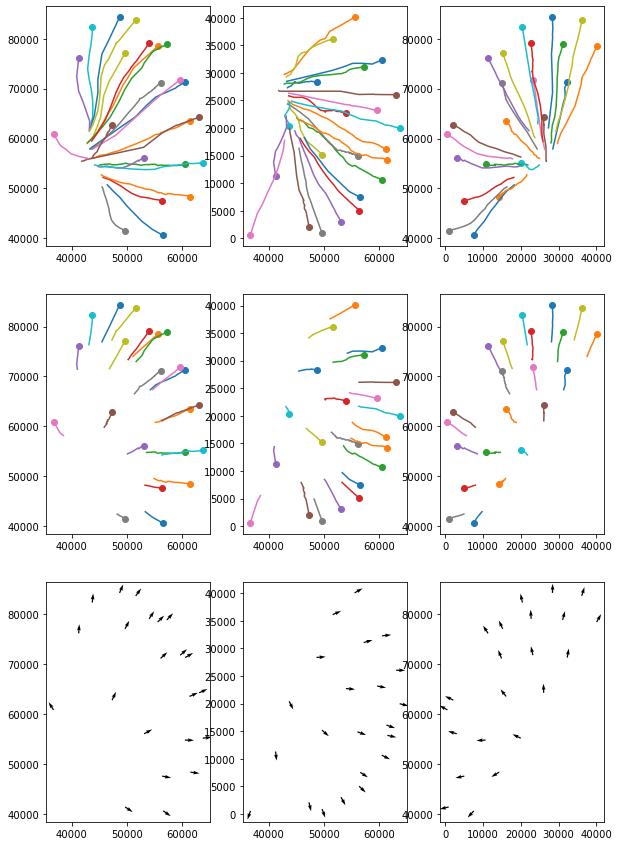

In [13]:
fig, ax = plt.subplots(3, 3, figsize=[10, 15])
axes = ax.flatten()

# Use the crystalline cone distance 
cc_extent = optics_df['lense thickness'] + optics_df['cone length (from the tip)']
exclude_om = cc_extent.isna()

mean_center = np.mean(center_points, axis=0)
pcs = dict()
norms = dict()

for om, p in om_points.items():
    if exclude_om[om]:
        print(f"skip {om}")
        continue
    else:
        # Make sure the first index is the most distal coord
        assert(np.linalg.norm(mean_center - p[0]) > np.linalg.norm(mean_center - p[1]))
        ### Full length
        axes[0].plot(p[:, 0], p[:, 1])
        axes[0].scatter(p[0, 0], p[0, 1])

        axes[1].plot(p[:, 0], p[:, 2])
        axes[1].scatter(p[0, 0], p[0, 2])

        axes[2].plot(p[:, 2], p[:, 1])
        axes[2].scatter(p[0, 2], p[0, 1])


        norm = np.linalg.norm(p[-1] - p[0])
        norms[om] = norm

        ### 

        while np.linalg.norm(p[-1] - p[0]) > cc_extent[om] * 1000.0:    
            p = np.delete(p, -1, 0)

        ###
        # Show data
        axes[3].plot(p[:, 0], p[:, 1])
        axes[3].scatter(p[0, 0], p[0, 1])

        axes[4].plot(p[:, 0], p[:, 2])
        axes[4].scatter(p[0, 0], p[0, 2])

        axes[5].plot(p[:, 2], p[:, 1])
        axes[5].scatter(p[0, 2], p[0, 1])

        # PCA to obtain unit vectors
        pca = PCA(n_components=1)
        pca.fit(p)
        c = pca.components_[0]
        # Invert sign of PC so the transformed unit is larger near lens 
        if np.dot(c, p[-1]) > np.dot(c, p[0]):
            c = c * -1

        pcs[om] = c
        norm = np.linalg.norm(p[-1] - p[0])

        axes[6].quiver(p[0, 0], p[0, 1], norm*c[0], norm*c[1])
        axes[7].quiver(p[0, 0], p[0, 2], norm*c[0], norm*c[2])
        axes[8].quiver(p[0, 2], p[0, 1], norm*c[2], norm*c[1])

# axes[0].scatter(mean_center[0], mean_center[1], s=200, marker='x', c='k')
# axes[1].scatter(mean_center[0], mean_center[2], s=200, marker='x', c='k')
# axes[2].scatter(mean_center[2], mean_center[1], s=200, marker='x', c='k')
# axes[3].scatter(mean_center[0], mean_center[1], s=200, marker='x', c='k')
# axes[4].scatter(mean_center[0], mean_center[2], s=200, marker='x', c='k')
# axes[5].scatter(mean_center[2], mean_center[1], s=200, marker='x', c='k')
# axes[6].scatter(mean_center[0], mean_center[1], s=200, marker='x', c='k')
# axes[7].scatter(mean_center[0], mean_center[2], s=200, marker='x', c='k')
# axes[8].scatter(mean_center[2], mean_center[1], s=200, marker='x', c='k')

n = np.array([n for o, n in norms.items()])

In [14]:
def hex_distance(o1: str, o2: str) -> float:
    c1 = np.array(om_to_hex(o1, scale_factor=1.0))
    c2 = np.array(om_to_hex(o2, scale_factor=1.0))
    
    return np.linalg.norm(c1-c2)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

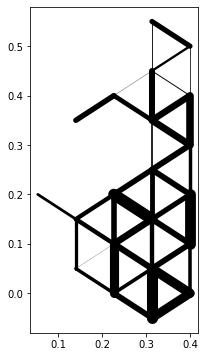

In [16]:
fig, ax = plt.subplots(1, figsize=[3, 6])

om_pairs = list(combinations(om_points.keys(), 2))
pair_angle = dict()

for o1, o2 in om_pairs:
    if exclude_om[o1] or exclude_om[o2]:
        continue
    
    if hex_distance(o1, o2) > 1.1:
        continue
    else:
        x1, y1 = om_to_hex(o1)
        x2, y2 = om_to_hex(o2)
        this_angle = angle_between(pcs[o1], pcs[o2])

        pair_angle[o1+o2] = this_angle
        w = (pair_angle[o1+o2] - 0.5) * 30
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
#         ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
#                     fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')


In [17]:
pair_angle = pd.Series(pair_angle)
display(np.degrees(pair_angle.mean()))
display(np.degrees(pair_angle.std()))
display(len(pair_angle))
#display(np.degrees(pair_angle.std(ddof=0)))

20.14053709677793

7.225345064220885

41

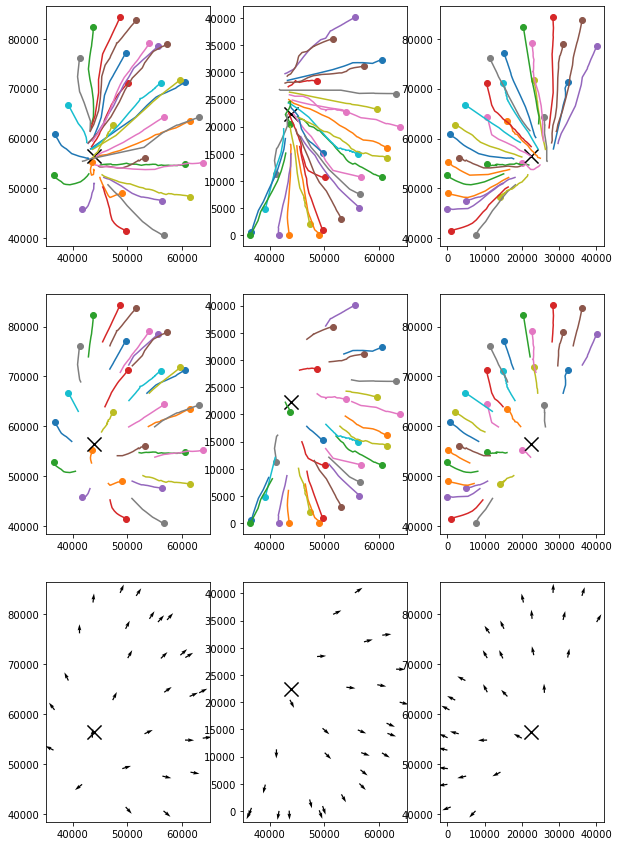

In [9]:
fig, ax = plt.subplots(3, 3, figsize=[10, 15])
axes = ax.flatten()

# Use the crystalline cone distance 
distal_extent = 10000
mean_center = np.mean(center_points, axis=0)
pcs = dict()
norms = dict()

for om, p in om_points.items():
    # Make sure the first index is the most apical coord
    assert(np.linalg.norm(mean_center - p[0]) > np.linalg.norm(mean_center - p[1]))
    ### Full length
    axes[0].plot(p[:, 0], p[:, 1])
    axes[0].scatter(p[0, 0], p[0, 1])
    
    axes[1].plot(p[:, 0], p[:, 2])
    axes[1].scatter(p[0, 0], p[0, 2])
    
    axes[2].plot(p[:, 2], p[:, 1])
    axes[2].scatter(p[0, 2], p[0, 1])
    
    
    norm = np.linalg.norm(p[-1] - p[0])
    norms[om] = norm
    
    ### 
    
    while np.linalg.norm(p[-1] - p[0]) > distal_extent:    
        p = np.delete(p, -1, 0)
    ###
    # Show data
    axes[3].plot(p[:, 0], p[:, 1])
    axes[3].scatter(p[0, 0], p[0, 1])
    
    axes[4].plot(p[:, 0], p[:, 2])
    axes[4].scatter(p[0, 0], p[0, 2])
    
    axes[5].plot(p[:, 2], p[:, 1])
    axes[5].scatter(p[0, 2], p[0, 1])
    
    # PCA to obtain unit vectors
    pca = PCA(n_components=1)
    pca.fit(p)
    c = pca.components_[0]
    # Invert sign of PC so the transformed unit is larger near lens 
    if np.dot(c, p[-1]) > np.dot(c, p[0]):
        c = c * -1
        
    pcs[om] = c
    norm = np.linalg.norm(p[-1] - p[0])

    axes[6].quiver(p[0, 0], p[0, 1], norm*c[0], norm*c[1])
    axes[7].quiver(p[0, 0], p[0, 2], norm*c[0], norm*c[2])
    axes[8].quiver(p[0, 2], p[0, 1], norm*c[2], norm*c[1])
    
axes[0].scatter(mean_center[0], mean_center[1], s=200, marker='x', c='k')
axes[1].scatter(mean_center[0], mean_center[2], s=200, marker='x', c='k')
axes[2].scatter(mean_center[2], mean_center[1], s=200, marker='x', c='k')
axes[3].scatter(mean_center[0], mean_center[1], s=200, marker='x', c='k')
axes[4].scatter(mean_center[0], mean_center[2], s=200, marker='x', c='k')
axes[5].scatter(mean_center[2], mean_center[1], s=200, marker='x', c='k')
axes[6].scatter(mean_center[0], mean_center[1], s=200, marker='x', c='k')
axes[7].scatter(mean_center[0], mean_center[2], s=200, marker='x', c='k')
axes[8].scatter(mean_center[2], mean_center[1], s=200, marker='x', c='k')

n = np.array([n for o, n in norms.items()])

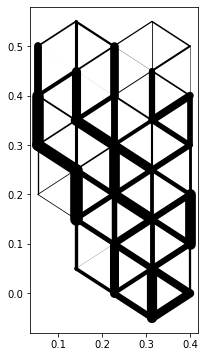

In [10]:
fig, ax = plt.subplots(1, figsize=[3, 6])

om_pairs = list(combinations(om_points.keys(), 2))
pair_angle = dict()

for o1, o2 in om_pairs:
    
    if hex_distance(o1, o2) > 1.1:
        continue
    else:
        x1, y1 = om_to_hex(o1)
        x2, y2 = om_to_hex(o2)
        this_angle = angle_between(pcs[o1], pcs[o2])

        pair_angle[o1+o2] = this_angle
        w = (pair_angle[o1+o2] - 0.5) * 30
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
#         ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
#                     fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')


In [11]:
pair_angle = pd.Series(pair_angle)
display(np.degrees(pair_angle.mean()))
display(np.degrees(pair_angle.var()))
#display(np.degrees(pair_angle.std(ddof=0)))

22.132752283927488

1.5037160392427944